In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
import os
import pandas as pd
import json

## 1. Propensity score matching

In [113]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Observational study
We have 2 groups: "treated" vs "control"
The question is: was the treatment effective on the worker? That is, did it improved his earnings? did it depend on any of the other variables? (age, origin, marriage, education)
We need a way to measure effectiveness based on change in earnings

treatment assignment: Z = 1 (treated) and Z = 0 (control) -> treat
response if subject is treated: r_t -> how re78 differs from re74 and re75 (Z=1)
response if subject is control: r_c -> how re78 differs from re74 and re75 (Z=0)
observed covariates (features x) -> age, educ, black, hispan, married, nodegree
unobserved covariates ->  Naive model: exclude them because assume “Only observed variables determine treatment assignment”. Bad, naive model is almost never true. -> Use propensity score.
"Adjustments using a model attempt to compare people who are not directly
comparable — people of somewhat different ages or smoking habits — removing
these differences using a mathematical structure that has elements estimated from
the data at hand."


Propensity score -> "if naive model is true, it equals the probability to treat"
e(x) = P(Z=1|x)
Computed by logistic regression. Features x, label Z



In [114]:
# print the shape of the DataFrame
data.shape

(614, 11)

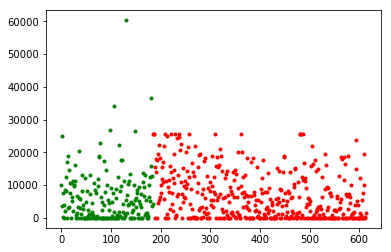

In [115]:
plt.plot(data[data['treat']==1].loc[:,'re78'],'.g')
plt.plot(data[data['treat']==0].loc[:,'re78'],'.r')

In [116]:
data_not_treated = data[data['treat']==0].reset_index().loc[:,'re78']
data_treated = data[data['treat']==1].reset_index().loc[:,'re78']

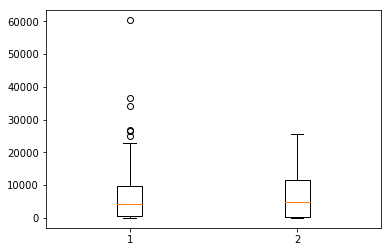

In [117]:
%matplotlib inline
data_to_plot = [data_treated, data_not_treated]
plot = plt.boxplot(data_to_plot)

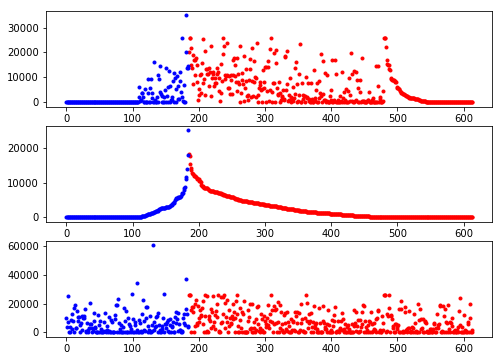

In [118]:
fig = plt.figure(figsize=(8, 6)) 
plt.subplot(3,1,1)
plt.plot(data[data['treat'] == 0].loc[:,'re74'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'re74'],'.b')
plt.subplot(3,1,2)
plt.plot(data[data['treat'] == 0].loc[:,'re75'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'re75'],'.b')
plt.subplot(3,1,3)
plt.plot(data[data['treat'] == 0].loc[:,'re78'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'re78'],'.b')

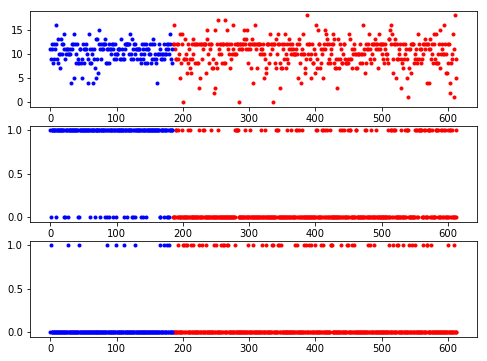

In [119]:
fig = plt.figure(figsize=(8, 6)) 
plt.subplot(3,1,1)
plt.plot(data[data['treat'] == 0].loc[:,'educ'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'educ'],'.b')
plt.subplot(3,1,2)
plt.plot(data[data['treat'] == 0].loc[:,'black'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'black'],'.b')
plt.subplot(3,1,3)
plt.plot(data[data['treat'] == 0].loc[:,'hispan'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'hispan'],'.b')

In [120]:
data['treat'].count()

614

In [125]:
total_treated = data['treat'].sum()
total_untreated = data['treat'].count() - total_treated

In [138]:
pc_black_treated

84.324324324324323

In [142]:
# Treated people demographics
total_black_treated = data[data['treat'] == 1].loc[:,'black'].sum()
total_hispanic_treated = data[data['treat'] == 1].loc[:,'hispan'].sum()
total_white_treated = total_treated - (total_black_treated + total_hispanic_treated)

pc_black_treated = 100*total_black_treated/total_treated
pc_hispan_treated = 100*total_hispanic_treated/total_treated
pc_white_treated = 100*total_white_treated/total_treated

print('Among treated, {:0.2f}% are black, {:0.2f}% are hispanic and {:0.2f}% are white'.format(pc_black_treated,pc_hispan_treated,pc_white_treated))

Among treated, 84.32% are black, 5.95% are hispanic and 9.73% are white


In [143]:
# Treated people demographics
total_black_untreated = data[data['treat'] == 0].loc[:,'black'].sum()
total_hispanic_untreated = data[data['treat'] == 0].loc[:,'hispan'].sum()
total_white_untreated = total_untreated - (total_black_untreated + total_hispanic_untreated)

pc_black_untreated = 100*total_black_untreated/total_untreated
pc_hispan_untreated = 100*total_hispanic_untreated/total_untreated
pc_white_untreated = 100*total_white_untreated/total_untreated

print('Among untreated, {:0.2f}% are black, {:0.2f}% are hispanic and {:0.2f}% are white'.format(pc_black_untreated,pc_hispan_untreated,pc_white_untreated))

Among untreated, 20.28% are black, 14.22% are hispanic and 65.50% are white


KeyError: 'TV'

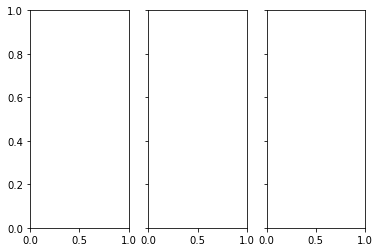

In [9]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV', y='sales', ax=axs[0], figsize=(16, 8), grid=True)
data.plot(kind='scatter', x='radio', y='sales', ax=axs[1], grid=True)
data.plot(kind='scatter', x='newspaper', y='sales', ax=axs[2], grid=True)